# Video activity classification on hmdb51 dataset

**HMDB: a large human motion database:** [Original Dataset link](https://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/)
* About 2GB for a total of 7,000 clips distributed in 51 action classes.
* The original source dataset is extracted and split into a stratified 80/20 train-test split.
* Train-test split dataset and required scripts: [Dataset & scripts link](https://drive.google.com/drive/folders/1-tJndYAlE2UeMz4ZWqTJjSy-vuTB3WKJ?usp=drive_link)

## Dataset loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

In [4]:
zip_path = "/content/drive/My Drive/Research/HMDB51 Video Dataset/hmdb51.zip"
extract_to = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [5]:
train_data_path = "/content/dataset/hmdb51/hmdb51_train"
test_data_path = "/content/dataset/hmdb51/hmdb51_test"

In [6]:
label_types = os.listdir(train_data_path)
print("Total number of classes: ", len(label_types))

Total number of classes:  51


*Reducing the number of classes to 5 for faster computations*

In [7]:
label_types = label_types[:5]
label_types

['laugh', 'ride_bike', 'drink', 'talk', 'stand']

## Preparing Training Data

In [8]:
import numpy as np
import pandas as pd

In [9]:
video_data = []

for cls in label_types:
  all_videos = os.listdir(train_data_path + '/' + cls)

  for video in all_videos[:32]:
    video_data.append((cls, str(train_data_path + '/' + cls) + '/' + video))

# Train dataframe
train_df = pd.DataFrame(data=video_data, columns=['Class', 'Video Path'])

In [10]:
train_df.head()

,Class,Video Path
0,laugh,/content/dataset/hmdb51/hmdb51_train/laugh/Can...
1,laugh,/content/dataset/hmdb51/hmdb51_train/laugh/sky...
2,laugh,/content/dataset/hmdb51/hmdb51_train/laugh/Bes...
3,laugh,/content/dataset/hmdb51/hmdb51_train/laugh/Bes...
4,laugh,/content/dataset/hmdb51/hmdb51_train/laugh/Sky...


## Preparing Test Data

In [11]:
video_data = []

for cls in label_types:
  all_videos = os.listdir(test_data_path + '/' + cls)

  for video in all_videos[:8]:
    video_data.append((cls, str(test_data_path + '/' + cls) + '/' + video))

# Test dataframe
test_df = pd.DataFrame(data=video_data, columns=['Class', 'Video Path'])

In [12]:
test_df.head()

,Class,Video Path
0,laugh,/content/dataset/hmdb51/hmdb51_test/laugh/Craz...
1,laugh,/content/dataset/hmdb51/hmdb51_test/laugh/Laug...
2,laugh,/content/dataset/hmdb51/hmdb51_test/laugh/Skyp...
3,laugh,/content/dataset/hmdb51/hmdb51_test/laugh/big_...
4,laugh,/content/dataset/hmdb51/hmdb51_test/laugh/Best...


In [13]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 160
Total videos for testing: 40


## Video data preprocessing

In [14]:
import cv2
import tensorflow as tf
from tensorflow import keras

### Video load and crop

In [15]:
IMG_SIZE = 224

In [16]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

### Feature Extraction using CNN: InceptionV3 Transfer Learning

In [17]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Label Encoding

In [18]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["Class"]))

In [19]:
label_processor.get_vocabulary()

[np.str_('drink'),
 np.str_('laugh'),
 np.str_('ride_bike'),
 np.str_('stand'),
 np.str_('talk')]

### Complete Video Processing Utility

In [32]:
# Hyperparameters

BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [33]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["Video Path"].values.tolist()
    labels = df["Class"].values

    # Convert class labels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain booleans denoting if a timestep is masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [34]:
train_data, train_labels = prepare_all_videos(train_df, train_data_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

In [35]:
test_data, test_labels = prepare_all_videos(test_df, test_data_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [36]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

print(f"train_labels in train set: {train_labels.shape}")
print(f"test_labels in test set: {test_labels.shape}")

Frame features in train set: (160, 20, 2048)
Frame masks in train set: (160, 20)
Frame features in test set: (40, 20, 2048)
Frame masks in test set: (40, 20)
train_labels in train set: (160, 1)
test_labels in test set: (40, 1)


## The Sequence Model: Gated Recurrent Units

- The extracted video frame features, masks and encoded labels are input to a sequence model consisting of recurrent layers like GRU (Gated Recurrent Units)

In [37]:
# Utility for sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [38]:
EPOCHS = 30
# Utility for running experiments.
def run_experiment():
    filepath = "/content/drive/My Drive/Research/Model checkpoints/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [39]:
history, sequence_model = run_experiment()

Epoch 1/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.1250 - loss: 1.6127
Epoch 1: val_loss improved from inf to 2.27427, saving model to /content/drive/My Drive/Research/Model checkpoints/video_classifier.weights.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.2125 - loss: 1.5311 - val_accuracy: 0.0000e+00 - val_loss: 2.2743
Epoch 2/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.3125 - loss: 1.4554
Epoch 2: val_loss did not improve from 2.27427
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3507 - loss: 1.4065 - val_accuracy: 0.0000e+00 - val_loss: 2.3023
Epoch 3/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3125 - loss: 1.2870
Epoch 3: val_loss did not improve from 2.27427
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3274 - loss: 1.3655 - val_accuracy: 0.0000e+00 - val_loss: 2.2867
Epoch 4/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2500 - loss: 1.4811
Epoch 4: val_loss improved from 2.27427 to 2.25449, saving model to /content/

## Model Evaluation

In [40]:
sequence_model.evaluate([test_data[0], test_data[1]], test_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4333 - loss: 1.4689


[1.5420258045196533, 0.4000000059604645]

In [41]:
import matplotlib.pyplot as plt

In [42]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

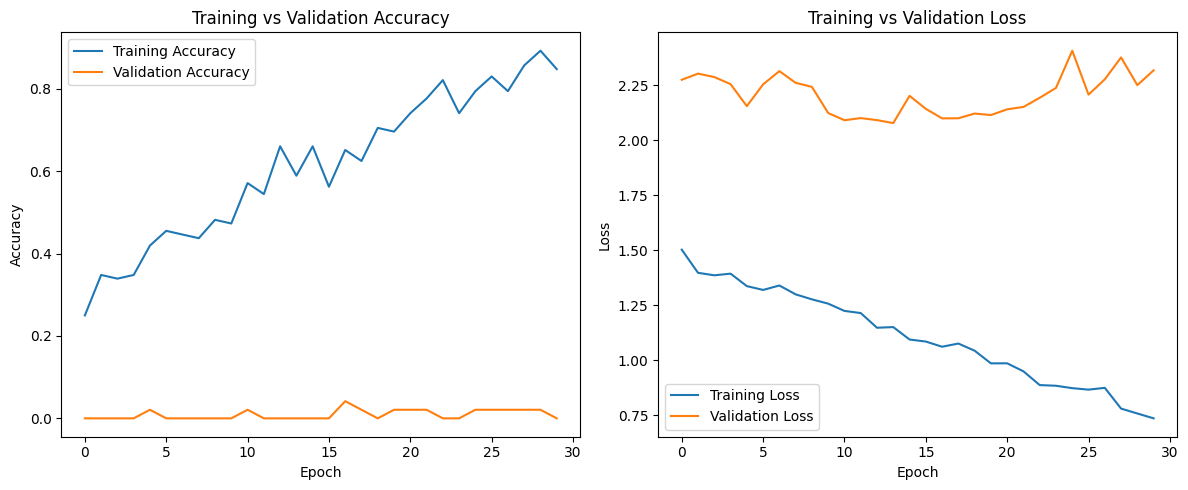

In [43]:
plot_training_history(history)

## Inference

In [44]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

In [45]:
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

In [46]:
test_video = np.random.choice(test_df["Video Path"].values.tolist())
test_video_class = test_df[test_df['Video Path'] == test_video].Class

print(f"Test video path: {test_video}")
print(f"Test video class: {test_video_class}")

Test video path: /content/dataset/hmdb51/hmdb51_test/ride_bike/Yorki_Kassy_beim_Fahrrad_fahren_ride_bike_f_cm_np1_ri_med_1.avi
Test video class: 12    ride_bike
Name: Class, dtype: object


In [47]:
test_frames = sequence_prediction(test_video)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
  ride_bike: 47.80%
  drink: 28.75%
  laugh: 15.56%
  stand:  4.04%
  talk:  3.85%
